In [1]:
%reset
import tensorflow as tf
import keras
import pickle as pk
import matplotlib.pyplot as pl
import matplotlib
import numpy as np
import pdb

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


2021-12-14 06:24:40.827985: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# The neural network architecture that we'll use in the example below is based on:

See https://github.com/eriklindernoren/Keras-GAN/blob/master/context_encoder/context_encoder.py

## Data location and dimensions

In [2]:
#The data are "cutouts" from full-sky maps made from observations by the Planck satellite.
#These maps were constructed at an observing frequency of 857 GHz
data_dir = './cutout_data/'
# this file contains some cutouts that are "off star", i.e. centered at random locations on the sky
# and not on star locations
offstar_file = 'cutouts_1000offstarfirstpass_01.pk'
offstar_multi = 'cutouts_1000offstarmultifreq_01.pk'

## Load the cutout data

In [3]:
#multi freq data
cutout_data_mf = pk.load(open(data_dir + offstar_multi, 'rb'))
print(cutout_data_mf.keys())
ll = cutout_data_mf['l'] # galatic longitude of the cutout
bb = cutout_data_mf['b'] # galactic latitude of the cutout

#get cutouts
cutouts_orig_mf = cutout_data_mf['cutouts']
print(cutout_data_mf['planck_files'])
print(cutouts_orig_mf.shape)

#one-axis array
cutouts_multi = np.append(cutouts_orig_mf[0], cutouts_orig_mf[1], axis=0)
print(cutouts_multi.shape)

dict_keys(['planck_files', 'cutouts', 'l', 'b'])
['planck_545.fits', 'planck_857.fits']
(2, 1000, 200, 200)
(2000, 200, 200)


## Plot a few cutouts

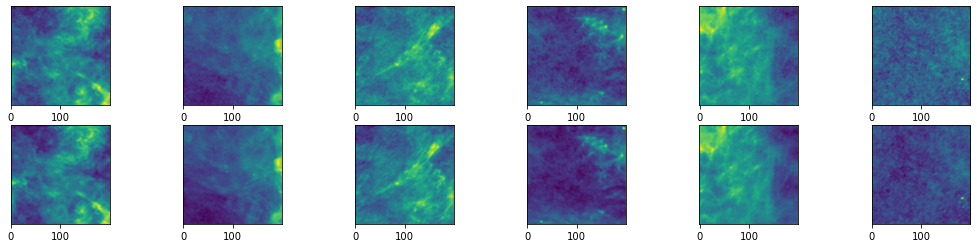

In [4]:
#plot some cutouts from both frequencies
nplots = 6
fig, ax = pl.subplots(2,nplots, figsize = (nplots*3., 4))
for ii in range(0,nplots):
    ax[0,ii].imshow(np.log(cutouts_multi[ii,:,:]))
    ax[1,ii].imshow(np.log(cutouts_multi[1000 + ii,:,:]))
    ax[0,ii].yaxis.set_visible(False)
    ax[1,ii].yaxis.set_visible(False)

## Reduce the dimensionality of the cutouts
And generate more data by flipping images

In [7]:
#The iniital cutouts have a dimension of 200x200.  We'll reduce the dimension to dim_reduced x dim_reduced
#to speed up the analysis
dim_reduced = 32
#We're going to mask out a small part of the center of the cutout with dimension dim_mask x dim_mask
dim_mask = int(dim_reduced/4)

(72000, 32, 32)


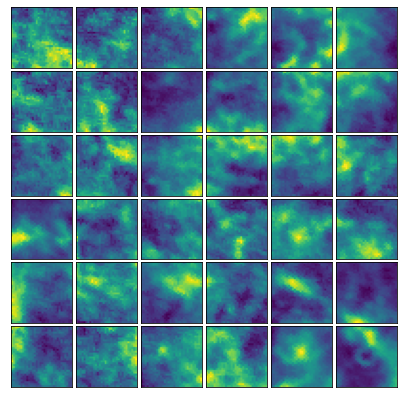

In [8]:
#make cutouts of smaller dimensions by tiling the original 200x200 image nxn times
n_cuts = int(200/dim_reduced)

cutouts_many = np.empty([0,dim_reduced,dim_reduced])

fig, ax = pl.subplots(n_cuts,n_cuts, figsize = (7,7))

for x in range(0,n_cuts):
    min_x = x * dim_reduced
    max_x = (x+1) * dim_reduced
    for y in range(0,n_cuts):
        min_y = y * dim_reduced
        max_y = (y+1) * dim_reduced
        some_cutouts = cutouts_multi[:, min_x:max_x, min_y:max_y]
        cutouts_many = np.append(cutouts_many,some_cutouts,axis=0)
        ax[x,y].imshow((some_cutouts[0,:,:]))
        ax[x,y].yaxis.set_visible(False)
        ax[x,y].xaxis.set_visible(False)

pl.subplots_adjust(wspace=0, hspace=0.05)
print(cutouts_many.shape)

(288000, 32, 32)


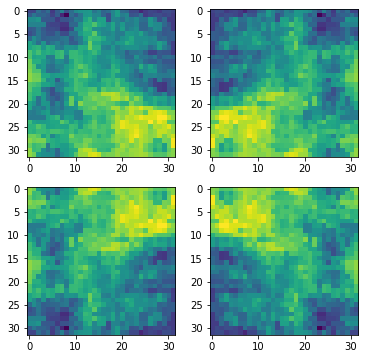

In [9]:
#Old way of reducing dimensionality

#orig_dims = cutouts_multi.shape
#min_ind = int(orig_dims[1]/2 - dim_reduced/2)
#max_ind = int(orig_dims[1]/2 + dim_reduced/2)
#cutouts = cutouts_multi[:, min_ind:max_ind, min_ind:max_ind]

#new setup and flip test indexing
cutouts = cutouts_many
end_shape = cutouts.shape[0]

#flip horizontaly and append
cutouts_fliplr = np.flip(cutouts,axis=2)
cutouts = np.append(cutouts,cutouts_fliplr,axis=0)

#flip vert and app
cutouts_flipud = np.flip(cutouts,axis=1)
cutouts = np.append(cutouts,cutouts_flipud,axis=0)

print(cutouts.shape)

#check by plot
fig, ax = pl.subplots(2,2, figsize = (6, 6))
ax[0,0].imshow(np.log(cutouts[0,:,:]))
ax[0,1].imshow(np.log(cutouts[end_shape,:,:]))

ax[1,0].imshow(np.log(cutouts[2*end_shape,:,:]))
ax[1,1].imshow(np.log(cutouts[3*end_shape,:,:]))
    
    
#fig.savefig('./network_out/example_images.png')

## Set up the neural network

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


2021-12-14 06:25:16.439736: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-14 06:25:16.441449: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-14 06:25:16.505546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2021-12-14 06:25:16.506318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:1c:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2021-12-14 06:25:16.506336: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-14 06

In [11]:
#randomly shuffle with a seed for testing consistency
import random

random.seed(420)
random.shuffle(cutouts)

#this is necesary for the network to run, since testiung is not done by batches 
#it cannot function with an extremely large dataset
test_size = 6000
split_index = int(cutouts.shape[0] - test_size)

#fast_reduced_dataset = cutouts[:8000,:,:]


cutouts_train = cutouts[:split_index,:,:]
#cutouts_train = fast_reduced_dataset
cutouts_test = cutouts[split_index:,:,:]

print(cutouts_train.shape)
print(cutouts_test.shape)

(282000, 32, 32)
(6000, 32, 32)


In [12]:
from __future__ import print_function, division

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras import losses
from tensorflow.keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

class ContextEncoder():
    def __init__(self):
        self.img_rows = dim_reduced
        self.img_cols = dim_reduced
        self.mask_height = dim_mask
        self.mask_width = dim_mask
        #777777777777
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.missing_shape = (self.mask_height, self.mask_width, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates the missing
        # part of the image
        masked_img = Input(shape=self.img_shape)
        gen_missing = self.generator(masked_img)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines
        # if it is generated or if it is a real image
        valid = self.discriminator(gen_missing)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model(masked_img , [gen_missing, valid])
        self.combined.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights = l_weights,
            #loss_weights=[0.999, 0.001],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        # Encoder
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(512, kernel_size=1, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))

        # Decoder
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation('tanh'))

        model.summary()

        masked_img = Input(shape=self.img_shape)
        gen_missing = model(masked_img)

        return Model(masked_img, gen_missing)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.missing_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.missing_shape)
        validity = model(img)

        return Model(img, validity)

    def mask_randomly(self, imgs):
        y1 = np.random.randint(0, self.img_rows - self.mask_height, imgs.shape[0])
        y2 = y1 + self.mask_height
        x1 = np.random.randint(0, self.img_rows - self.mask_width, imgs.shape[0])
        x2 = x1 + self.mask_width

        masked_imgs = np.empty_like(imgs)
        missing_parts = np.empty((imgs.shape[0], self.mask_height, self.mask_width, self.channels))
        for i, img in enumerate(imgs):
            masked_img = img.copy()
            _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i]
            missing_parts[i] = masked_img[_y1:_y2, _x1:_x2, :].copy()
            masked_img[_y1:_y2, _x1:_x2, :] = 0
            masked_imgs[i] = masked_img

        return masked_imgs, missing_parts, (y1, y2, x1, x2)

    def mask_center(self, imgs):
        y1 = int(self.img_rows/2) - int(self.mask_height/2)
        y2 = y1 + self.mask_height
        x1 = int(self.img_rows/2) - int(self.mask_width/2)
        x2 = x1 + self.mask_width

        masked_imgs = np.empty_like(imgs)
        missing_parts = np.empty((imgs.shape[0], self.mask_height, self.mask_width, self.channels))
        for i, img in enumerate(imgs):
            masked_img = img.copy()
            missing_parts[i] = masked_img[y1:y2, x1:x2, :].copy()
            masked_img[y1:y2, x1:x2, :] = -100
            masked_imgs[i] = masked_img

        return masked_imgs, missing_parts, (y1, y2, x1, x2)

    def train(self, epochs, batch_size, sample_interval=50):

        # Load the dataset
        #(X_train, y_train), (_, _) = cifar10.load_data()
        #pdb.set_trace()
        X_train = np.expand_dims(np.log(cutouts_train),axis=3)
        
        # Rescale -1 to 1
        #77777777777
        X_mean = np.mean(X_train)
        X_std = np.std(X_train)
        X_train = (X_train - X_mean)/X_std
        #y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        
        d_l_plh = []
        g_l_plh = []
        test_plh = []

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            masked_imgs, missing_parts, _ = self.mask_center(imgs)

            # Generate a batch of new images
            gen_missing = self.generator.predict(masked_imgs)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(missing_parts, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_missing, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_l_plh.append(d_loss[0])

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(masked_imgs, [missing_parts, valid])
            g_l_plh.append(g_loss[0])

            # Plot the progress
            #print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
            
            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                idx = np.random.randint(0, X_train.shape[0], 6)
                imgs = X_train[idx]
                self.sample_images(epoch, imgs)
            
            #test model at interavals
            if epoch % 15 == 0:
                self.test()
                test_plh.append([epoch, self.test_d_l[0], self.test_g_l[0], 0.999 * self.test_g_l[0] + \
                                0.001 * self.test_d_l[0]])
                
        self.train_d_l = d_l_plh
        self.train_g_l = g_l_plh
        self.test_ers_out = test_plh
        
    def test(self):
        
        #data and rescale
        X_test = np.expand_dims(np.log(cutouts_test),axis=3)
        X_mean = np.mean(X_test)
        X_std = np.std(X_test)
        X_test = (X_test - X_mean)/X_std

        # Adversarial ground truths
        valid = np.ones((X_test.shape[0], 1))
        fake = np.zeros((X_test.shape[0], 1))
        
        test_d_l_plh = []
        test_g_l_plh = []
        
        # use all images and mask them
        imgs = X_test
        masked_imgs, missing_parts, _ = self.mask_center(imgs)

        # Generate a batch of new images
        gen_missing = self.generator.predict(masked_imgs)
        
        # Discriminoator loss
        d_loss_real = self.discriminator.train_on_batch(missing_parts, valid,)
        d_loss_fake = self.discriminator.train_on_batch(gen_missing, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        test_d_l_plh.append(d_loss[0])
        
        #get generator loss
        g_loss = self.combined.train_on_batch(masked_imgs, [missing_parts, valid])
        test_g_l_plh.append(g_loss[0])
        
        self.test_d_l = test_d_l_plh
        self.test_g_l = test_g_l_plh
        
    def predictions(self):
        
        #prepare data
        X_test = np.expand_dims(np.log(cutouts_test),axis=3)
        X_mean = np.mean(X_test)
        X_std = np.std(X_test)
        X_test = (X_test - X_mean)/X_std
        imgs = X_test
        
        #output predicted images
        masked_imgs, missing_parts, (y1, y2, x1, x2) = self.mask_center(imgs)
        gen_missing = self.generator.predict(masked_imgs)

        imgs = 0.5 * imgs + 0.5
        masked_imgs = 0.5 * masked_imgs + 0.5
        gen_missing = 0.5 * gen_missing + 0.5
        filled_in = imgs.copy()
        filled_in[y1:y2, x1:x2, :] = gen_missing
        return(filled_in)
        
    def sample_images(self, epoch, imgs):
        r, c = 3, 6

        masked_imgs, missing_parts, (y1, y2, x1, x2) = self.mask_center(imgs)
        gen_missing = self.generator.predict(masked_imgs)

        imgs = 0.5 * imgs + 0.5
        masked_imgs = 0.5 * masked_imgs + 0.5
        gen_missing = 0.5 * gen_missing + 0.5

        fig, axs = plt.subplots(r, c)
        for i in range(c):
            axs[0,i].imshow(np.log(imgs[i, :,:]))
            axs[0,i].axis('off')
            axs[1,i].imshow(np.log(masked_imgs[i, :,:]))
            axs[1,i].axis('off')
            filled_in = imgs[i].copy()
            filled_in[y1:y2, x1:x2, :] = gen_missing[i]
            axs[2,i].imshow(np.log(filled_in))
            axs[2,i].axis('off')
        img_name = f"{epoch},{l_weights}"
        #fig.savefig("network_output/images/%d.png" % epoch)
        fig.savefig(f"network_output/images/{img_name}.png")
        plt.close()
        
    def save_model(self):

        def save(model, model_name):
            model_path = "network_output/saved_model/%s.json" % model_name
            weights_path = "network_output/saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")




In [13]:
#train model with the following parameters
l_weights= [0.999, 0.001]
epochs = 401
cne = ContextEncoder()
cne.train(epochs=epochs, batch_size=128, sample_interval=200)
print("Done")

2021-12-14 06:25:38.430173: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-14 06:25:38.686535: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2021-12-14 06:25:38.687453: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:1c:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2021-12-14 06:25:38.687479: I tensorflow/stream_executor/platform/de

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 4, 64)          640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 64)          256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 2, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 256)         2

2021-12-14 06:25:43.880759: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-14 06:25:43.881471: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2021-12-14 06:25:43.998530: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-12-14 06:25:44.965749: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-12-14 06:25:45.007570: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-12-14 06:25:45.294731: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
/tmp/ipykernel_86256/1846153097.py:296: Runtime

Done


In [14]:
#after training test model and record dscriminator and generator loss
cne.test()
print(cne.test_d_l,cne.test_g_l)

[0.002236815169453621] [0.17757152020931244]


## Analysis and results

In [15]:
#availible loss values
print("Train Loss - Generator, Epochs:", len(cne.train_g_l), type(cne.train_g_l))
print("Train Loss - Discriminator, Epochs:", len(cne.train_d_l), type(cne.train_d_l))

print("Final Test Loss - Generator:", cne.test_g_l)
print("Final Test Loss - Discriminator:", cne.test_d_l)

print("Continuous Test Losses, Shape:", np.array(cne.test_ers_out).shape)
print("Access variables = cnn. (train_g_l, train_d_l, test_g_l, test_d_l, test_err_out)")

Train Loss - Generator, Epochs: 401 <class 'list'>
Train Loss - Discriminator, Epochs: 401 <class 'list'>
Final Test Loss - Generator: [0.17757152020931244]
Final Test Loss - Discriminator: [0.002236815169453621]
Continuous Test Losses, Shape: (27, 4)
Access variables = cnn. (train_g_l, train_d_l, test_g_l, test_d_l, test_err_out)


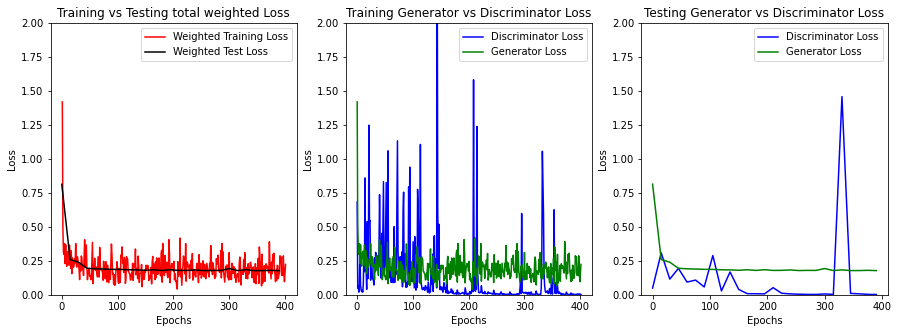

In [16]:
#graphs of losses

train_lw_total = l_weights[0]*np.array(cne.train_g_l) + l_weights[1]*np.array(cne.train_d_l)
epochs_plot = np.arange(1,epochs+1,1)

fig, ax = pl.subplots(1,3, figsize = (15,5))
#test vs train total
ax[0].set_title("Training vs Testing total weighted Loss")
ax[0].plot(epochs_plot,train_lw_total,label="Weighted Training Loss",c='r')
ax[0].plot(np.array(cne.test_ers_out)[:,0],np.array(cne.test_ers_out)[:,3],label='Weighted Test Loss',c='k')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel('Loss')
ax[0].set_ylim(0,2)
ax[0].legend()

#train disc vs trin gen vs train wieght
ax[1].set_title("Training Generator vs Discriminator Loss")
ax[1].plot(epochs_plot,cne.train_d_l,label="Discriminator Loss",c='b')
ax[1].plot(epochs_plot,cne.train_g_l,label="Generator Loss",c='g')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,2)
ax[1].legend()

#test disc vs test gen vs test total
ax[2].set_title("Testing Generator vs Discriminator Loss")
ax[2].plot(np.array(cne.test_ers_out)[:,0],np.array(cne.test_ers_out)[:,1],label='Discriminator Loss',c='b')
ax[2].plot(np.array(cne.test_ers_out)[:,0],np.array(cne.test_ers_out)[:,2],label='Generator Loss',c='g')
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel('Loss')
ax[2].set_ylim(0,2)
ax[2].legend()

fig.savefig(f"network_output/images/{l_weights}.png")
plt.show()

In [74]:
#might incorpoirate it into the CNN class but not now
def predictions():
    
    X_test = np.expand_dims(np.log(cutouts_test),axis=3)
    X_mean = np.mean(X_test)
    X_std = np.std(X_test)
    X_test = (X_test - X_mean)/X_std
    imgs = X_test
        
    #output predicted images
    masked_imgs, missing_parts, (y1, y2, x1, x2) = cne.mask_center(imgs)
    gen_missing = cne.generator.predict(masked_imgs)
    filled_in = imgs.copy()
    filled_in[:, y1:y2, x1:x2, :] = gen_missing
        
    #output mean corrected images
    filled_in_mean = imgs.copy()
    for i in range(imgs.shape[0]):
        img_mean = np.mean(imgs[i,:,:,:])
        mean_array = np.full((y2-y1,x2-x1,1),img_mean)
        filled_in_mean[i, y1:y2, x1:x2,:] = mean_array
        
    return imgs, filled_in, filled_in_mean

In [75]:
#get prediction for testing
orig, gen_out, mean_out = predictions()

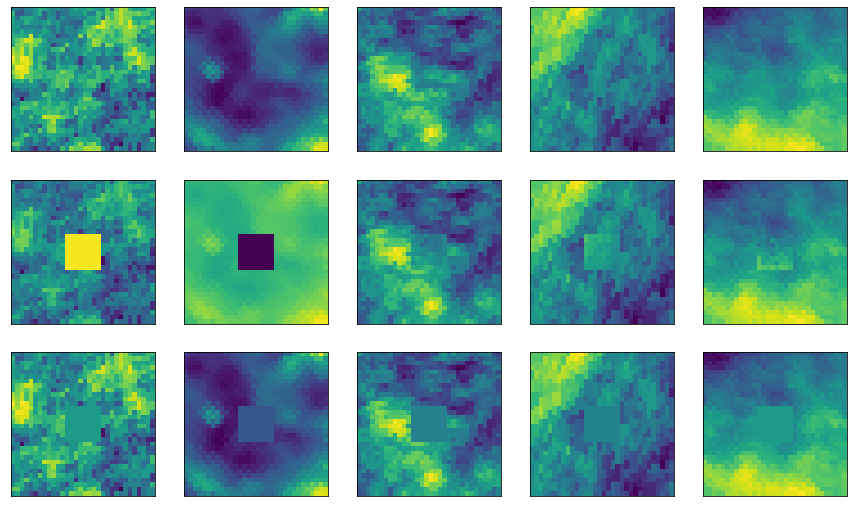

In [80]:
#figure of generated and mean corrected images
nplots = 5
offset = 5
fig, ax = pl.subplots(3,nplots, figsize = (nplots*3., 9))
for ii in range(0,nplots):
    #orig
    ax[0,ii].imshow((orig[ii+offset,:,:]))
    ax[0,ii].xaxis.set_visible(False)
    ax[0,ii].yaxis.set_visible(False)
    
    #gen
    ax[1,ii].imshow((gen_out[ii+offset,:,:]))
    ax[1,ii].xaxis.set_visible(False)
    ax[1,ii].yaxis.set_visible(False)
    
    #mean
    ax[2,ii].imshow((mean_out[ii+offset,:,:]))
    ax[2,ii].xaxis.set_visible(False)
    ax[2,ii].yaxis.set_visible(False)

In [84]:
#make evaluation method for aperture thing currently using the mean square
#setup variables
len_g = len(gen_out)
rms_err = np.empty((len_g,2))
rms_gen = 0
rms_mean = 0
start_x = (int(dim_reduced/2) - int(dim_mask/2))
start_y = start_x

#cycle for all images in the predicted set along x,y
for i in range(0,len_g):
    for x in range(0,dim_mask):
        for y in range(0,dim_mask):
            rms_gen = rms_gen + (orig[i,start_x + x, start_y + y] - gen_out[i,start_x + x, start_y + y])**2
            rms_mean = rms_mean + (orig[i,start_x + x, start_y + y] - mean_out[i,start_x + x, start_y + y])**2
    rms_err[i,0] = rms_gen/(dim_mask**2)
    rms_gen = 0
    rms_err[i,1] = rms_mean/(dim_mask**2)
    rms_mean = 0

print(rms_err.shape)

(6000, 2)


(0.0, 1.0)

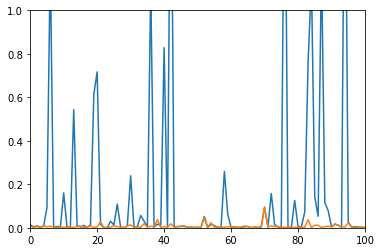

In [85]:
imms = np.arange(0,len_g,1)
plt.plot(imms,((rms_err[:,0])))
plt.plot(imms,((rms_err[:,1])))

plt.xlim(0,100)
plt.ylim(0,1)

In [20]:
#final results

In [21]:
#graphs of final reuslts

In [23]:
#insanely long grid search for best combination fo loss weights and batch sizes
#intensity graphs on papaer